# Тестирование предобученной BERT для анализа тональности отзывов
Глазунов А.В.

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 15.2MB/s 
     |████████████████████████████████| 3.0MB 20.7MB/s 
     |████████████████████████████████| 890kB 19.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c4ab0862474f2bc7fcf3e165dabc067efdb65709d9f7a60347883536b9c43187
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('products_sentiment_train.tsv',header=None,sep='\t')
df_test = pd.read_csv('products_sentiment_test.tsv',header=0,sep='\t')

In [ ]:
df_train.head()

,0,1
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [ ]:
df_test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [ ]:
df_train.columns = ["text",0]
texts = pd.concat([df_train[["text"]],df_test[["text"]]],ignore_index=True)
texts

,text
0,"2 . take around 10,000 640x480 pictures ."
1,i downloaded a trial version of computer assoc...
2,the wrt54g plus the hga7t is a perfect solutio...
3,i dont especially like how music files are uns...
4,i was using the cheapie pail ... and it worked...
...,...
2495,i took perfect care of this player and still i...
2496,it 's a very intuitive program .
2497,the only drawback is the viewfinder is slightl...
2498,"it films 10 second video , for crying out loud ."


In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized = texts["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(2500, 114)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2500, 114)

In [ ]:
%%time
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

CPU times: user 6min 54s, sys: 48.6 s, total: 7min 43s
Wall time: 7min 43s


In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape

(2500, 768)

In [ ]:
labels = df_train[0]

In [ ]:
train_features = features[:2000]
test_features = features[2000:]

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
features_resampled, labels_resampled = ros.fit_resample(train_features,labels.values)


In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr_clf.predict(test_features)

In [ ]:
ID_test = df_test.Id

In [ ]:
ans = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans.head()

,Id,y
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


In [ ]:
ans.to_csv('submission_bert1.csv', index=False)

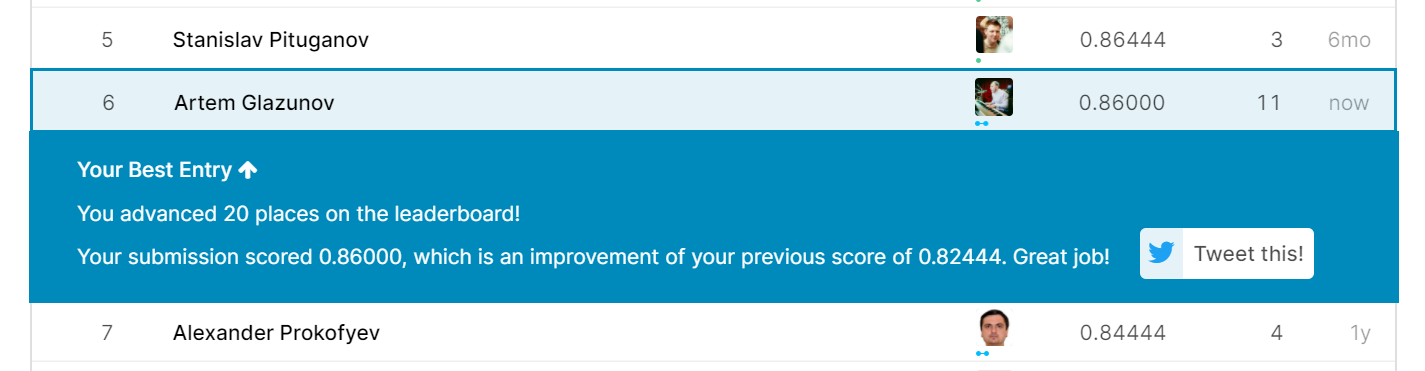

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svc_clf = LinearSVC()
svc_clf.fit(train_features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
y_pred2 = svc_clf.predict(test_features)

In [ ]:
ans2 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred2})
ans2.to_csv('submission_bert2.csv', index=False)

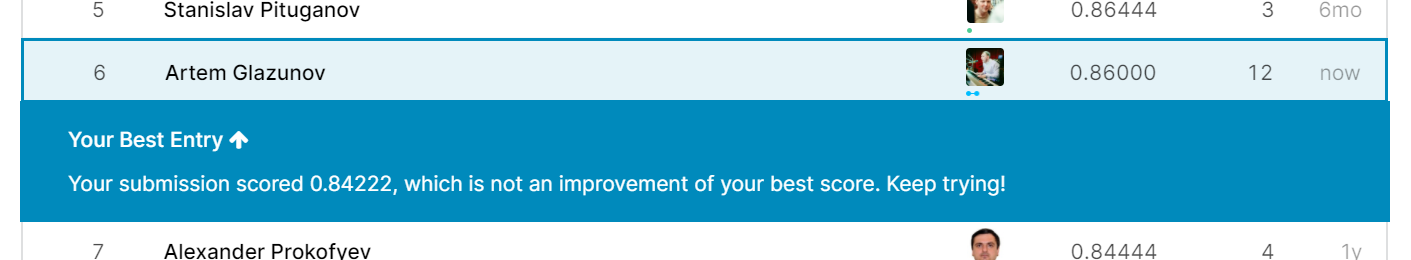

In [ ]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenized = texts["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(2500, 114)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2500, 114)

In [ ]:
%%time
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

CPU times: user 13min 59s, sys: 1min 44s, total: 15min 43s
Wall time: 15min 45s


In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape

(2500, 768)

In [ ]:
labels = df_train[0]

In [ ]:
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
train_features = features[:2000]
test_features = features[2000:]

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr_clf.predict(test_features)

In [ ]:
ID_test = df_test.Id

In [ ]:
ans3 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans3.head()

,Id,y
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1


In [ ]:
ans3.to_csv('submission_bert3.csv', index=False)

In [ ]:
import xgboost as xgb

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(train_features, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb_clf.predict(test_features)
ans4 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans4.to_csv('submission_bert4.csv', index=False)

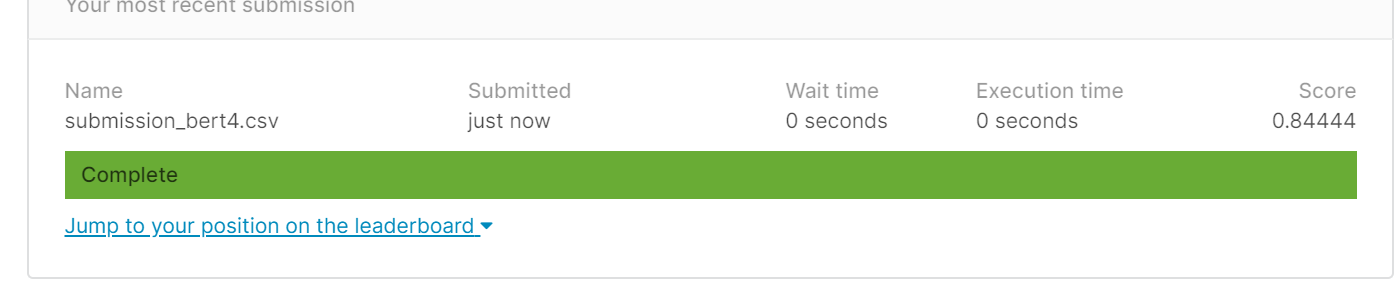

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth=7,n_estimators=200)
xgb_clf.fit(train_features, labels)
y_pred = xgb_clf.predict(test_features)
ans5 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans5.to_csv('submission_bert5.csv', index=False)

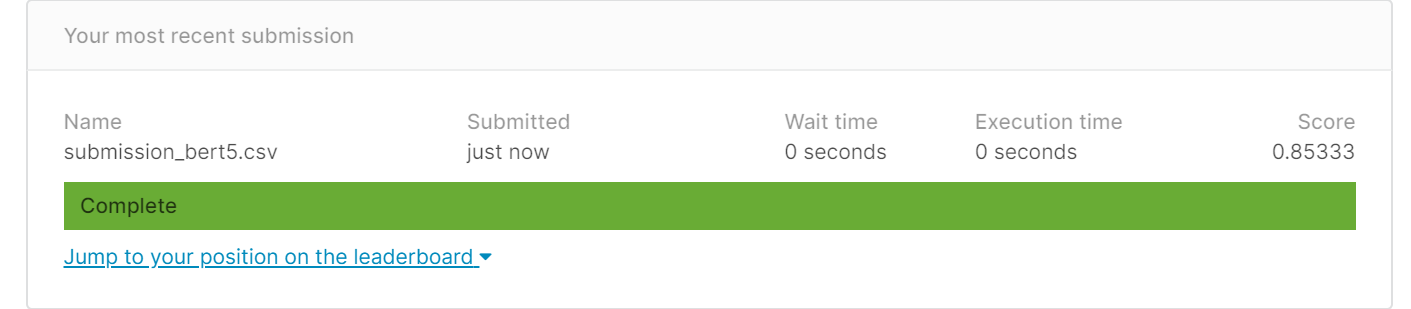

In [ ]:
%%time
xgb_clf = xgb.XGBClassifier(max_depth=10,n_estimators=1000)
xgb_clf.fit(train_features, labels)
y_pred = xgb_clf.predict(test_features)
ans6 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans6.to_csv('submission_bert6.csv', index=False)

CPU times: user 1min 31s, sys: 59.4 ms, total: 1min 31s
Wall time: 1min 31s


In [ ]:
%%time
xgb_clf = xgb.XGBClassifier(max_depth=7,n_estimators=500)
xgb_clf.fit(train_features, labels)
y_pred = xgb_clf.predict(test_features)
ans9 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans9.to_csv('submission_bert9.csv', index=False)

CPU times: user 1min 2s, sys: 39.1 ms, total: 1min 2s
Wall time: 1min 2s


In [ ]:
 from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
rf_clf = RandomForestClassifier(n_estimators=2000)
rf_clf.fit(train_features, labels)
y_pred = rf_clf.predict(test_features)
ans7 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans7.to_csv('submission_bert7.csv', index=False)

CPU times: user 1min 18s, sys: 92.3 ms, total: 1min 18s
Wall time: 1min 18s


In [ ]:
%%time
rf_clf = RandomForestClassifier(n_estimators=5000)
rf_clf.fit(train_features, labels)
y_pred = rf_clf.predict(test_features)
ans8 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans8.to_csv('submission_bert8.csv', index=False)

CPU times: user 3min 17s, sys: 483 ms, total: 3min 17s
Wall time: 3min 18s


In [ ]:
df_train[0].value_counts()

1    1274
0     726
Name: 0, dtype: int64

In [ ]:
np.sum(labels_resampled==0)

1274

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(features_resampled, labels_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr_clf.predict(test_features)
ans10 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans10.to_csv('submission_bert10.csv', index=False)

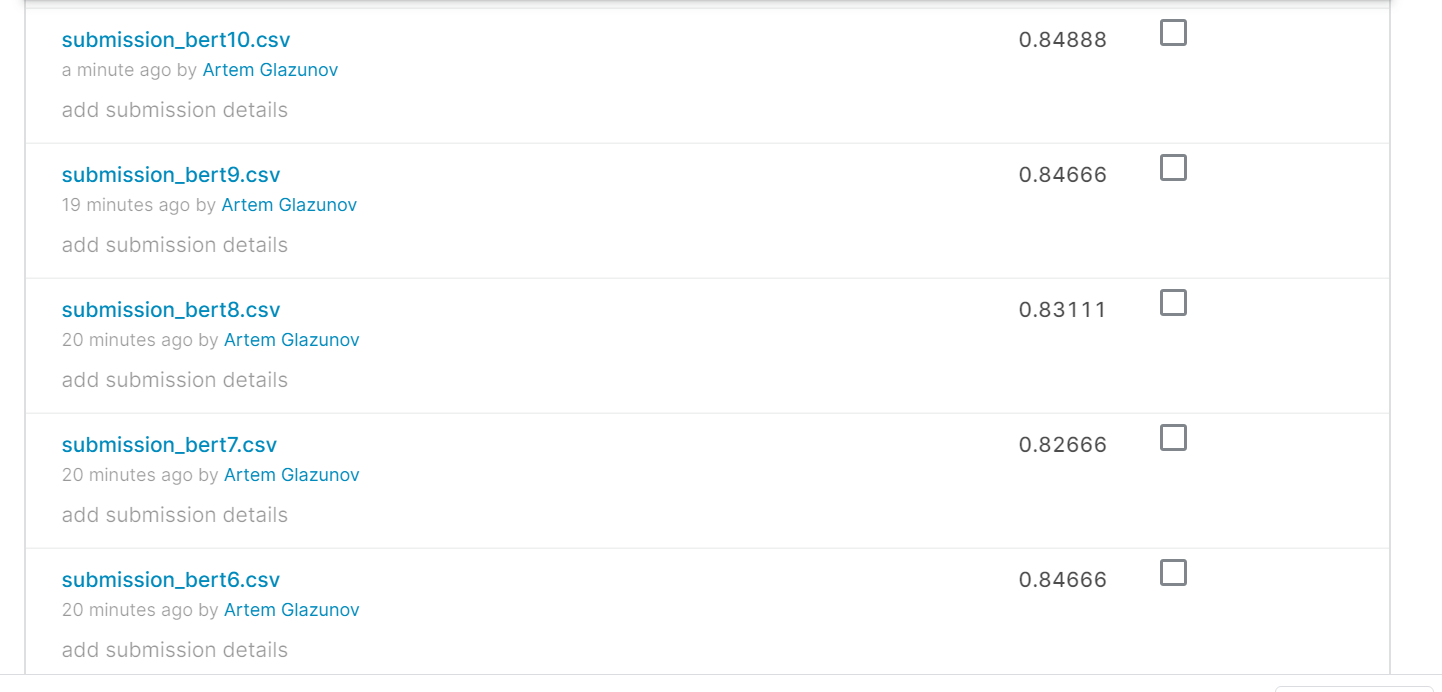

In [ ]:
feats_train,feats_val,labels_train,labels_val = train_test_split(train_features, labels, test_size = 0.3,\
                                                                   shuffle=True,random_state=42,\
                                                                   stratify = labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(feats_train, labels_train)
probs = lr_clf.predict_proba(feats_val)[:,1]



In [ ]:
probs

array([9.93649131e-01, 5.01915355e-03, 9.99983613e-01, 9.84079226e-02,
       2.75014714e-01, 8.73449946e-01, 9.98386733e-01, 6.29507199e-01,
       6.94678196e-02, 1.21870924e-01, 8.74987072e-01, 9.90659705e-01,
       9.79076815e-01, 1.22313188e-02, 9.37326234e-01, 3.99190616e-02,
       9.84274717e-01, 3.30519115e-01, 9.79653737e-01, 2.03735224e-01,
       6.03279424e-03, 3.46485294e-01, 9.81009484e-01, 3.78225561e-03,
       9.99658876e-01, 8.14418636e-01, 1.38432454e-04, 9.96319257e-01,
       9.76390944e-01, 4.74985234e-01, 9.95866184e-01, 9.91871772e-01,
       9.40268916e-01, 9.28215493e-01, 2.69875818e-01, 9.04743340e-01,
       6.94129156e-01, 9.97378467e-01, 4.05510311e-01, 9.59401839e-01,
       8.40529384e-01, 2.26024434e-01, 2.64319987e-01, 2.42467291e-01,
       9.99718468e-01, 1.53242546e-01, 1.04237617e-01, 9.95457585e-01,
       4.88539722e-01, 9.99179191e-01, 4.53253994e-02, 9.99983343e-01,
       3.33025255e-01, 9.98610805e-01, 9.99794785e-01, 9.00964458e-02,
      

In [ ]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

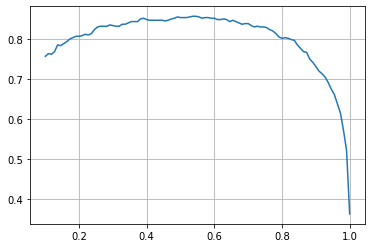

In [ ]:
thrshds = np.linspace(0.1,1,100)
scores = []
for thrshd in thrshds:
  pred = (probs > thrshd).astype(int)
  
  scores.append(accuracy_score(labels_val, pred))

plt.plot(thrshds,scores)
plt.grid()

In [ ]:
np.max(scores)

0.8566666666666667

In [ ]:
np.argmax(scores)

48

In [ ]:
thrshds[48]

0.5363636363636364

In [ ]:
thrshds[44]

0.5

In [ ]:
scores[44]

0.8533333333333334

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV
from tqdm import tqdm_notebook

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [ ]:
means = []
stds = []
Cs = np.logspace(-3,1,100)
for C  in tqdm_notebook(Cs):
  lr_clf = LogisticRegression(C=C)
  
  scores = cross_val_score(lr_clf,feats_train, labels_train,cv=skf)
  score_mean = scores.mean()
  score_std = scores.std()

  means.append(score_mean)
  stds.append(score_std) 

In [ ]:
Cs

array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02, 1.23284674e-02,
       1.35304777e-02, 1.48496826e-02, 1.62975083e-02, 1.78864953e-02,
       1.96304065e-02, 2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02, 3.76493581e-02,
       4.13201240e-02, 4.53487851e-02, 4.97702356e-02, 5.46227722e-02,
       5.99484250e-02, 6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.04761575e-01, 1.14975700e-01,
       1.26185688e-01, 1.38488637e-01, 1.51991108e-01, 1.66810054e-01,
      

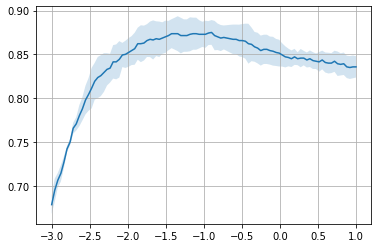

In [ ]:
Cs = np.array(Cs)
means = np.array(means)
stds=np.array(stds)
lines = plt.plot(np.log10(Cs), means, '-')
plt.fill_between(np.log10(Cs), means - stds, means + stds, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
plt.grid()

In [ ]:
np.max(means)


0.875

In [ ]:
np.argmax(means)

52

In [ ]:
10**np.log10(Cs)[52]


0.1261856883066021

In [ ]:
Cs[np.argmax(means)]

0.1261856883066021

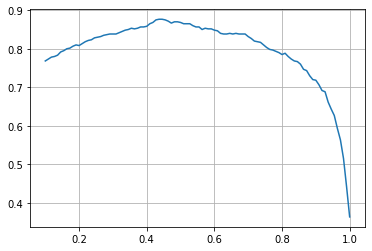

In [ ]:
lr_clf = LogisticRegression(C=Cs[np.argmax(means)])
lr_clf.fit(feats_train, labels_train)
probs = lr_clf.predict_proba(feats_val)[:,1]
thrshds = np.linspace(0.1,1,100)
scores = []
for thrshd in thrshds:
  pred = (probs > thrshd).astype(int)
  
  scores.append(accuracy_score(labels_val, pred))

plt.plot(thrshds,scores)
plt.grid()

In [ ]:
np.max(scores)

0.8766666666666667

In [ ]:
thrshds[np.argmax(scores)]

0.4363636363636364

In [ ]:
lr_clf = LogisticRegression(C=Cs[np.argmax(means)])
lr_clf.fit(train_features, labels)
probs = lr_clf.predict_proba(test_features)[:,1]

y_pred = (probs > thrshds[np.argmax(scores)]).astype(int)

ans12 = pd.DataFrame({'Id' : ID_test, 'y' : y_pred})
ans12.to_csv('submission_bert12.csv', index=False)

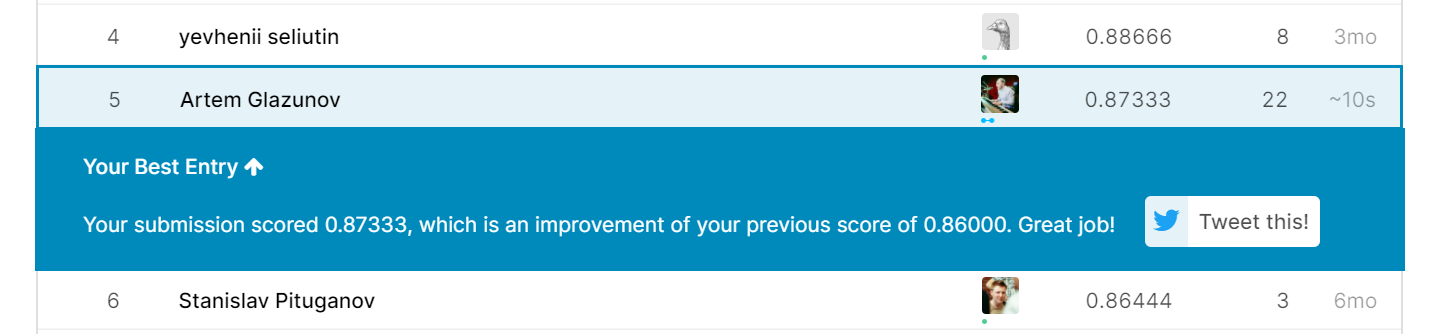